Входные данные:
3 csv файла - каждый файл -- это координаты gps, где человек находился какое-|то время

##### Информация
- latitude - Широта
- longitude - Долгота

Timestamp
- YYYY = year
- MM = month of year
- dd = day of month
- HH = hour of day
- mm = minute of hour
- Z = timezone offset

Duration - продолжительность пребывания человека в локации в мс

## Задания:
- 1- Посещали пользователи одинаковые места? Знают ли они друг друга?

- 2- Ввести метрику социальной активности
    - она должна учитывать количество мест, которое посетил пользователь, как далеко они друг от друга и как долго человек оставался там 
    - метрика должна позволять сравнивать пользователей и находить наиболее активных

In [1]:
#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3)

import geopandas
from geopandas.tools import geocode
import folium
from geopy.distance import geodesic

Откроем файлы и посмотрим данные

In [3]:
df1, df2, df3 = (
    pd.read_csv('person.1.csv', sep=';'),
    pd.read_csv('person.2.csv', sep=';'),
    pd.read_csv('person.3.csv', sep=';')
)

def open_df(name, data):
    print(name)
    print('-----------------------------')
    print('Количество дубликатов:', data.duplicated().sum())
    print('-----------------------------')
    print('Количество уникальных имен:\n', data.nunique())
    display(data.head(3))
    data.info()
    print('===========================================\n')

open_df('df1', df1)
open_df('df2', df2)
open_df('df3', df3)

df1
-----------------------------
Количество дубликатов: 0
-----------------------------
Количество уникальных имен:
 latitude                     446
longitude                    507
start_time(YYYYMMddHHmmZ)    549
duration(ms)                 549
dtype: int64


,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms)
0,-49.326958,-72.89073,201312251147-0300,1186491
1,-49.326930,-72.89073,201312251213-0300,4393711
2,-49.316610,-72.89890,201312251358-0300,842939


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   549 non-null    float64
 1   longitude                  549 non-null    float64
 2   start_time(YYYYMMddHHmmZ)  549 non-null    object 
 3   duration(ms)               549 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 17.3+ KB

df2
-----------------------------
Количество дубликатов: 0
-----------------------------
Количество уникальных имен:
 latitude                     544
longitude                    698
start_time(YYYYMMddHHmmZ)    763
duration(ms)                 760
dtype: int64


,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms)
0,51.057022,3.714476,201312250036+0100,19593588
1,51.056984,3.714681,201312250608+0100,30460679
2,51.038406,3.729655,201312251451+0100,964169


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   763 non-null    float64
 1   longitude                  763 non-null    float64
 2   start_time(YYYYMMddHHmmZ)  763 non-null    object 
 3   duration(ms)               763 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 24.0+ KB

df3
-----------------------------
Количество дубликатов: 0
-----------------------------
Количество уникальных имен:
 latitude                     259
longitude                    322
start_time(YYYYMMddHHmmZ)    357
duration(ms)                 357
dtype: int64


,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms)
0,51.216340,4.394143,201401061340+0100,9488434
1,51.205994,4.392227,201401061631+0100,430394
2,51.054200,4.447165,201401061643+0100,487049


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   357 non-null    float64
 1   longitude                  357 non-null    float64
 2   start_time(YYYYMMddHHmmZ)  357 non-null    object 
 3   duration(ms)               357 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 11.3+ KB



**Что есть:**
- пропусков нет
- дубликатов нет
- зашифрованное время и длительность в миллисекундах.

**Что сделаем:**
- перепишем названия столбцов
- приведем дату с учетом таймзоны
- выведем дату
- длительность в миллисекундах преобразуем к минутам и часам

In [4]:
# Преобразуем типы данных
def dt_df(name, data):
    print(name)
    print('-----------------------------')
    data.columns= ['latitude', 'longitude', 'start_time', 'duration_ms']
    data['start_time'] = pd.to_datetime(data['start_time'], utc=True)
    data['minutes'] = round(data['duration_ms']/ 60000, 1)
    data['hours'] = round(data['duration_ms']/ 3600000, 1)
    data['date'] = data['start_time'].dt.date
    display(data.head(3))
    data.info()
    print('===========================================\n')

dt_df('df1', df1)
dt_df('df2', df2)
dt_df('df3', df3)

df1
-----------------------------


,latitude,longitude,start_time,duration_ms,minutes,hours,date
0,-49.326958,-72.89073,2013-12-25 14:47:00+00:00,1186491,19.8,0.3,2013-12-25
1,-49.326930,-72.89073,2013-12-25 15:13:00+00:00,4393711,73.2,1.2,2013-12-25
2,-49.316610,-72.89890,2013-12-25 16:58:00+00:00,842939,14.0,0.2,2013-12-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   latitude     549 non-null    float64            
 1   longitude    549 non-null    float64            
 2   start_time   549 non-null    datetime64[ns, UTC]
 3   duration_ms  549 non-null    int64              
 4   minutes      549 non-null    float64            
 5   hours        549 non-null    float64            
 6   date         549 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(1)
memory usage: 30.1+ KB

df2
-----------------------------


,latitude,longitude,start_time,duration_ms,minutes,hours,date
0,51.057022,3.714476,2013-12-24 23:36:00+00:00,19593588,326.6,5.4,2013-12-24
1,51.056984,3.714681,2013-12-25 05:08:00+00:00,30460679,507.7,8.5,2013-12-25
2,51.038406,3.729655,2013-12-25 13:51:00+00:00,964169,16.1,0.3,2013-12-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   latitude     763 non-null    float64            
 1   longitude    763 non-null    float64            
 2   start_time   763 non-null    datetime64[ns, UTC]
 3   duration_ms  763 non-null    int64              
 4   minutes      763 non-null    float64            
 5   hours        763 non-null    float64            
 6   date         763 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(1)
memory usage: 41.9+ KB

df3
-----------------------------


,latitude,longitude,start_time,duration_ms,minutes,hours,date
0,51.216340,4.394143,2014-01-06 12:40:00+00:00,9488434,158.1,2.6,2014-01-06
1,51.205994,4.392227,2014-01-06 15:31:00+00:00,430394,7.2,0.1,2014-01-06
2,51.054200,4.447165,2014-01-06 15:43:00+00:00,487049,8.1,0.1,2014-01-06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   latitude     357 non-null    float64            
 1   longitude    357 non-null    float64            
 2   start_time   357 non-null    datetime64[ns, UTC]
 3   duration_ms  357 non-null    int64              
 4   minutes      357 non-null    float64            
 5   hours        357 non-null    float64            
 6   date         357 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(1)
memory usage: 19.6+ KB



Добавим "названия" людей и соединим таблицы

In [5]:
df1.insert(0, "person", 1)
df2.insert(0, "person", 2)
df3.insert(0, "person", 3)

df_concat = pd.concat([df1, df2, df3]).reset_index(drop=True)
df_concat.head(3)

,person,latitude,longitude,start_time,duration_ms,minutes,hours,date
0,1,-49.326958,-72.89073,2013-12-25 14:47:00+00:00,1186491,19.8,0.3,2013-12-25
1,1,-49.326930,-72.89073,2013-12-25 15:13:00+00:00,4393711,73.2,1.2,2013-12-25
2,1,-49.316610,-72.89890,2013-12-25 16:58:00+00:00,842939,14.0,0.2,2013-12-25


### Задание 1.1 
- Посещали пользователи одинаковые места? Знают ли они друг друга?

Посмотрим как распределены данные

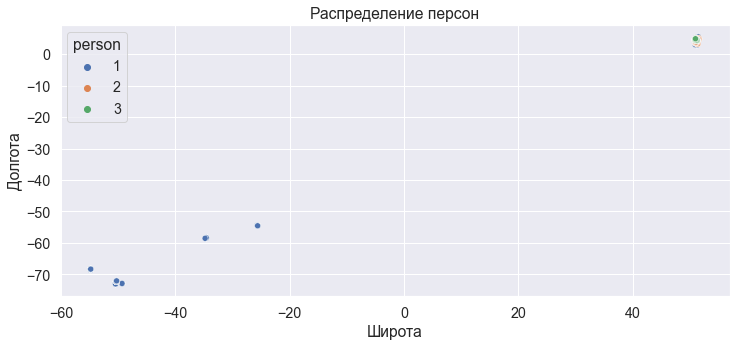

In [6]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df_concat, x="latitude", y="longitude", hue="person", palette="deep")
plt.title("Распределение персон")
plt.ylabel('Долгота')
plt.xlabel('Широта')
plt.show()


Посмотрим левый нижний угол

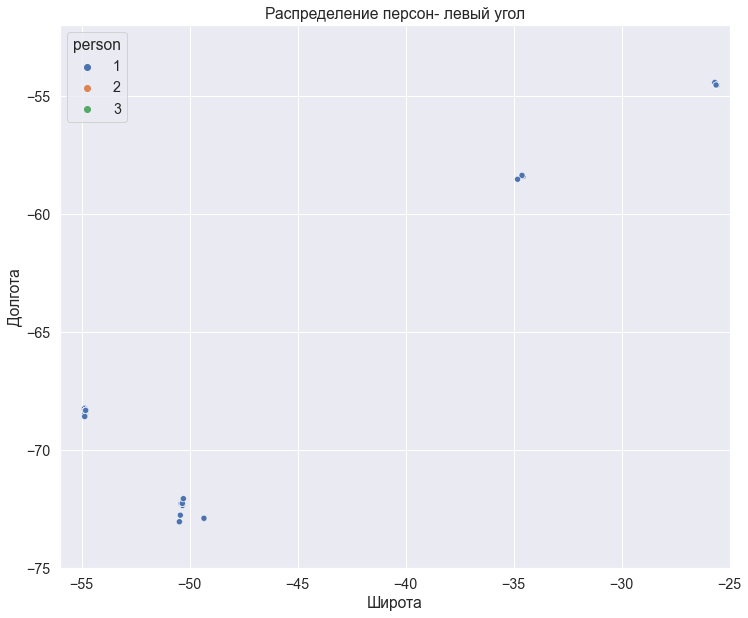

In [7]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_concat, x="latitude", y="longitude", hue="person", palette="deep")
plt.title("Распределение персон- левый угол")
plt.ylabel('Долгота')
plt.xlabel('Широта')

plt.ylim(-75, -52)
plt.xlim(-56, -25)
plt.show()

- Видно распределение только персоны 1. Пересечений с другими нет.
- Посмотрим другой угол.

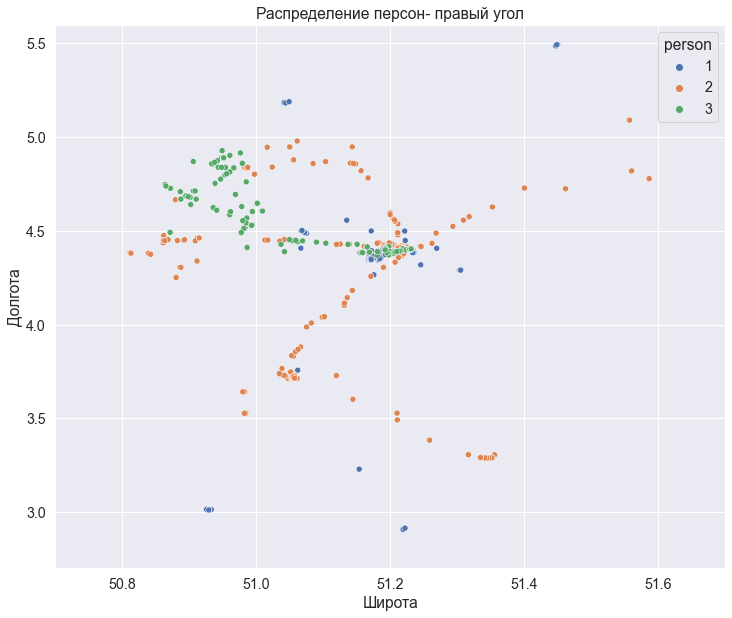

In [8]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_concat, x="latitude", y="longitude", hue="person", palette="deep")
plt.title("Распределение персон- правый угол")
plt.ylabel('Долгота')
plt.xlabel('Широта')

plt.ylim(2.7, 5.6)
plt.xlim(50.7, 51.7)
plt.show()

- Здесь видно распределение трех персон. Есть пересечения.

In [9]:
# Посмотрим на карте
mapit = folium.Map(location=[0, 0], zoom_start=3) 
for lat , lon in zip(df_concat.latitude , df_concat.longitude):
    folium.Marker( location=[lat, lon], fill_color='blue', radius=8 ).add_to( mapit )
mapit


Получили знакомую картинку как на скаттерплот.

Определим есть ли общие для пользователей места.

In [10]:
# Соберем список совпадающих latitude
lat_123 = []
for row in df1['latitude'].unique():
    if row in list(df2['latitude'].unique()):
        lat_123.append(row)
    else:
        row += 0

for row in df2['latitude'].unique():
    if row in list(df3['latitude'].unique()):
        lat_123.append(row)
    else:
        row += 0

for row in df3['latitude'].unique():
    if row in list(df1['latitude'].unique()):
        lat_123.append(row)
    else:
        row += 0
len(lat_123)

93

In [11]:
# Соберем список совпадающих longitude
lon_123 = []
for row in df1['longitude'].unique():
    if row in list(df2['longitude'].unique()):
        lon_123.append(row)
    else:
        row += 0
for row in df3['longitude'].unique():
    if row in list(df2['longitude'].unique()):
        lon_123.append(row)
    else:
        row += 0
for row in df1['longitude'].unique():
    if row in list(df3['longitude'].unique()):
        lon_123.append(row)
    else:
        row += 0
len(lon_123)

17

In [12]:
# Отсортируем по списку
df_concat_sort = (
    df_concat
    .query('latitude == @lat_123 and longitude == @lon_123')
    .sort_values(by='date', ascending=True)
    .reset_index(drop=True)
)
df_concat_sort.info()
df_concat_sort.set_index('date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   person       39 non-null     int64              
 1   latitude     39 non-null     float64            
 2   longitude    39 non-null     float64            
 3   start_time   39 non-null     datetime64[ns, UTC]
 4   duration_ms  39 non-null     int64              
 5   minutes      39 non-null     float64            
 6   hours        39 non-null     float64            
 7   date         39 non-null     object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), object(1)
memory usage: 2.6+ KB


,person,latitude,longitude,start_time,duration_ms,minutes,hours
date,,,,,,,
2014-01-04,2,51.216343,4.394154,2014-01-04 10:09:00+00:00,10075281,167.9,2.8
2014-01-04,2,51.216343,4.394157,2014-01-04 13:08:00+00:00,12345634,205.8,3.4
2014-01-07,3,51.216343,4.394155,2014-01-07 07:08:00+00:00,29794938,496.6,8.3
2014-01-09,3,51.216343,4.394154,2014-01-09 06:27:00+00:00,30072243,501.2,8.4
2014-01-13,3,51.216343,4.394157,2014-01-13 06:56:00+00:00,30352945,505.9,8.4
2014-01-14,2,51.216320,4.394157,2014-01-14 07:15:00+00:00,32304020,538.4,9.0
2014-01-14,3,51.216300,4.394105,2014-01-14 06:32:00+00:00,32569127,542.8,9.0
2014-01-15,2,51.216320,4.394156,2014-01-15 07:19:00+00:00,29968538,499.5,8.3
2014-01-16,2,51.216320,4.394155,2014-01-16 12:38:00+00:00,4634058,77.2,1.3


**Что сделали:**
- Выбрали координаты, которые есть у трех персон одновременно. 
- сравнив по дате, есть пересечение в координатах, но это не встреча "друзей", время и длительность не совпадают.
2014-02-28 - персоны 2 и 3 были в одном месте, длительностью 4 минуты - 2 персоны и 5 часов - 3 персоны. Время встречи не совпадает

**Ответы по заданию 1** 
- Посещали пользователи одинаковые места? - **Да.**
- Знают ли они друг друга?  -**Нет**

### Задание 1.2 
**Ввести метрику социальной активности**
- она должна учитывать количество мест, которое посетил пользователь, как далеко они друг от друга и как долго человек оставался там 
- метрика должна позволять сравнивать пользователей и находить наиболее активных

In [13]:
# Возьмем координаты и вычислим расстояние между местами в метрах
begin_coordinates = list(zip(df_concat['latitude'] , df_concat['longitude']))
next_coordinates = list(zip(df_concat['latitude'][1:] , df_concat['longitude'][1:]))
distance = []
for i, j in zip(begin_coordinates, next_coordinates):
    distance.append(round(geodesic(i, j).meters))

# Добавим список к таблице
df_concat['distance'] = pd.Series(distance)
df_concat.tail()

,person,latitude,longitude,start_time,duration_ms,minutes,hours,date,distance
1664,3,51.192430,4.398564,2014-03-24 16:20:00+00:00,264,0.0,0.0,2014-03-24,16382.0
1665,3,51.049310,4.453596,2014-03-24 16:27:00+00:00,238853,4.0,0.1,2014-03-24,23279.0
1666,3,50.898182,4.682842,2014-03-24 16:56:00+00:00,119533,2.0,0.0,2014-03-24,10685.0
1667,3,50.955710,4.804546,2014-03-24 17:02:00+00:00,62443,1.0,0.0,2014-03-24,6021.0
1668,3,50.951214,4.889936,2014-03-24 17:15:00+00:00,41054631,684.2,11.4,2014-03-24,NaN


In [14]:
# Метрика по дате показывает активность пользователей
place = (
    df_concat
    .groupby(['date', 'person'], as_index=False)
    .agg({'longitude': 'count', 'hours': 'sum', 'distance': 'sum'})
    .rename(columns={'longitude': 'place_count'})
)
place.head()

,date,person,place_count,hours,distance
0,2013-12-24,2,1,5.4,15.0
1,2013-12-25,1,5,21.6,2653.0
2,2013-12-25,2,8,27.0,107625.0
3,2013-12-26,1,9,4.4,123494.0
4,2013-12-26,2,10,18.5,29984.0


In [15]:
# Посмотрим максимальные и минимальные значения
place_sort = (
    place
    .groupby('person')
    .agg({'place_count': ['max', 'min'], 'hours': ['max', 'min'], 'distance': ['max', 'min']})
)
place_sort

place_count     hours         distance        
               max min   max  min         max     min
person                                               
1               28   1  35.9  0.0  11361794.0  1941.0
2               45   1  45.3  2.7    139089.0    15.0
3               16   1  25.4  0.0    162900.0    26.0


Активность персон по "количеству мест, шт"


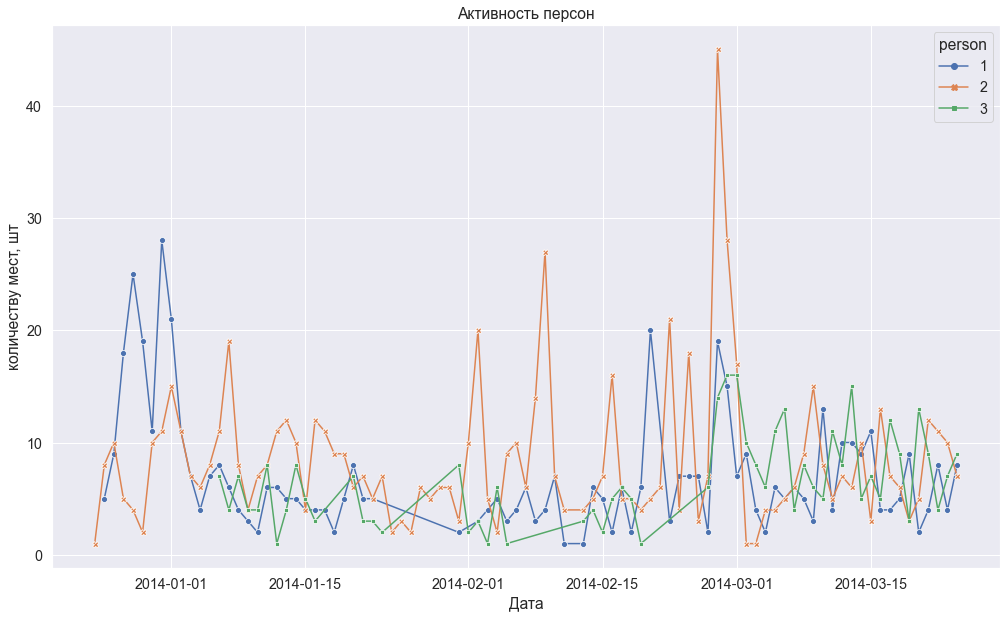

По параметру "количеству мест, шт"
 максимальное значение - 45 у персоны "2",
 минимальное значение - 1 у персоны "1"
------------------------------------------------------


Активность персон по "длительности, часов"


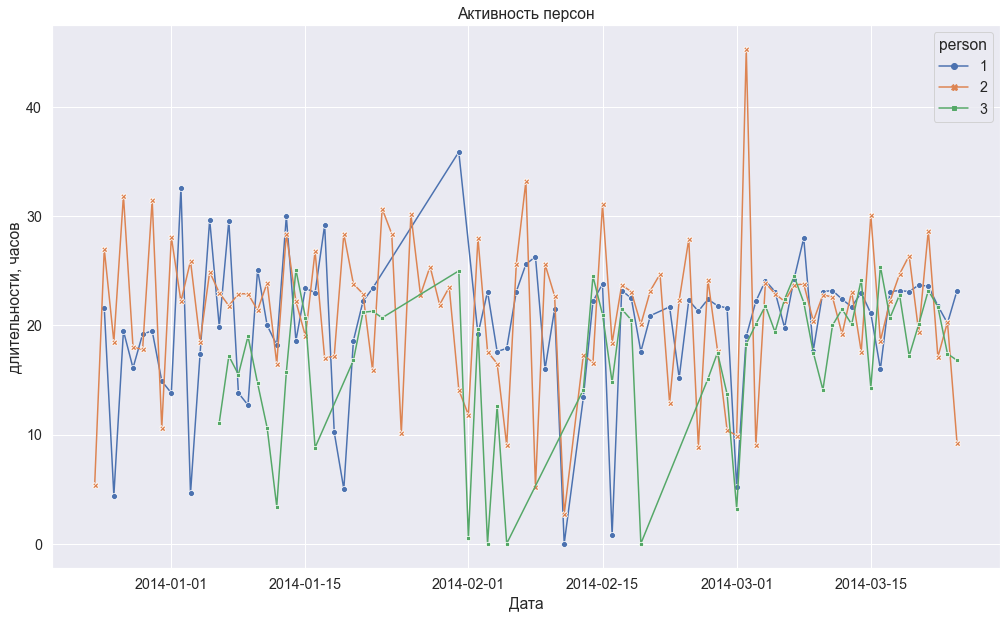

По параметру "длительности, часов"
 максимальное значение - 45.3 у персоны "2",
 минимальное значение - 0.0 у персоны "1"
------------------------------------------------------


Активность персон по "расстоянию между точками, метров"


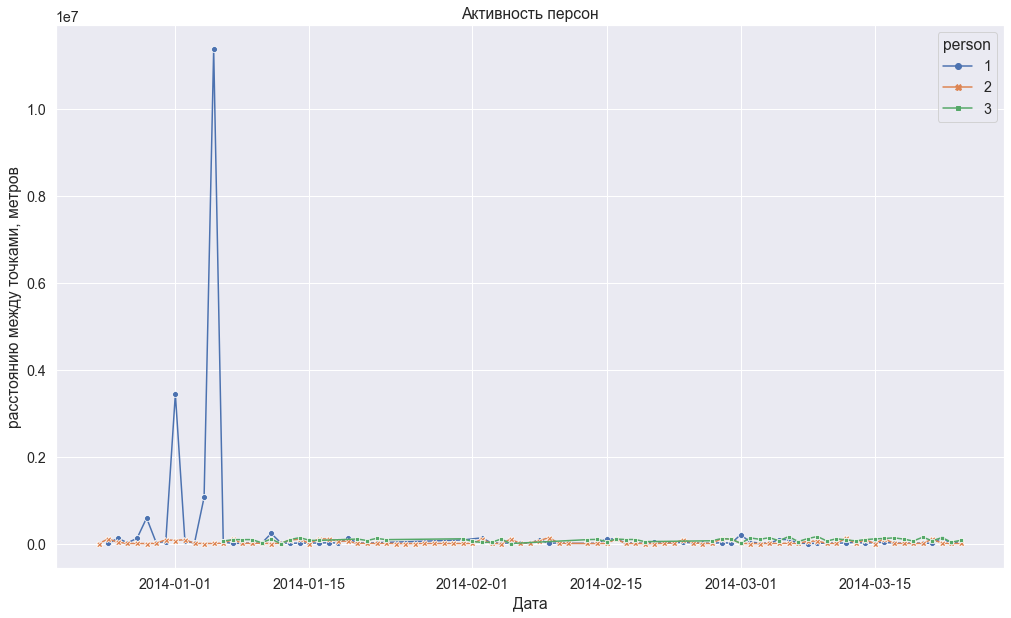

По параметру "расстоянию между точками, метров"
 максимальное значение - 11361794.0 у персоны "1",
 минимальное значение - 15.0 у персоны "2"
------------------------------------------------------



In [16]:
# Посмотрим динамику по пользователям
def metric(name, parameter):
        
        print(f'\nАктивность персон по "{name}"')
        plt.figure(figsize=(17, 10))
        sns.lineplot(data=place, x="date", y=parameter, hue="person", palette="deep", style="person",
        markers=True, dashes=False)
        plt.title("Активность персон")
        plt.ylabel(name)
        plt.xlabel('Дата')
        plt.show()

        print('По параметру "{}"\n максимальное значение - {} у персоны "{}",\n минимальное значение - {} у персоны "{}"'
                  .format(name, place_sort[parameter].max().iloc[0], place_sort[parameter].idxmax().iloc[0], 
                          place_sort[parameter].min().iloc[1], place_sort[parameter].idxmin().iloc[1]))
        print('------------------------------------------------------\n')

metric('количеству мест, шт', 'place_count')
metric('длительности, часов', 'hours')
metric('расстоянию между точками, метров', 'distance')

Последний график из-за выброса в значениях, перекрыл графики других дней и пользователей. Выделим его отдельно.

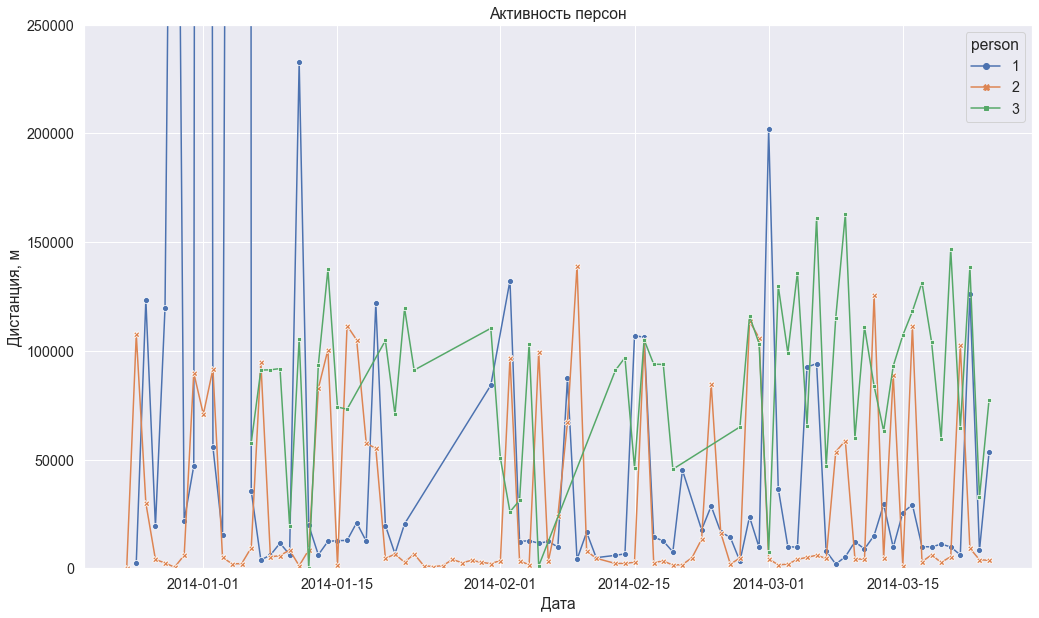

In [17]:
plt.figure(figsize=(17, 10))
sns.lineplot(data=place, x="date", y='distance', hue="person", palette="deep", style="person",
    markers=True, dashes=False)
plt.title("Активность персон")
plt.ylabel('Дистанция, м')
plt.xlabel('Дата')

plt.ylim(0, 250000)
plt.show()

Пользователь 3 больше совершает далеких поездок, чем 2.

In [18]:
# Метрика активности пользователей
person = (
    df_concat
    .groupby('person')
    .agg({'longitude': 'count', 'hours': 'sum', 'distance': 'sum'})
    .rename(columns={'longitude': 'place_count'})
)

person['days'] = round(person['hours'] / 24)              #переведем часы в дни
person['distance_km'] = person['distance'] / 1000         #переведем м в км
person.head()

,place_count,hours,distance,days,distance_km
person,,,,,
1,549,1588.9,19052649.0,66.0,19052.649
2,763,1904.9,2633169.0,79.0,2633.169
3,357,931.1,4716879.0,39.0,4716.879


Выводы:
- Пользователи посещали одинаковые места. 
- Они не знают друг друга, т.к. время посещения мест, длительность не совпадают.
- Самый активный- 2 пользователь:
    - по количеству посещения мест (763 шт),
    - по количеству времени (79 дней).
- А по расстояниям самый активный- 1 пользователь, преодолел свыше 19 тысяч км  за 66 дней.